# Mapa de la Cuenca del Río Balsas

Para generar este mapa se utiliza información de Centro Geo y del INEGI. Se descarga la información de la cuenca del Río Balsas y se intersecta con la información de los municipios del INEGI para obtener información de la población y viviendas en la cuenca. Se genera un mapa con la cuenca y los estados que abarca.

In [1]:
import geopandas as gpd
import zipfile
import requests
import pandas as pd
import contextily as cx
from matplotlib import pyplot as plt

In [2]:
#Descarga y unzip

def download_unzip(url, path):
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36'})
    with open(path, 'wb') as f:
        f.write(r.content)
    with zipfile.ZipFile(path, 'r') as z:
        z.extractall(path.replace('.zip', ''))

In [3]:
#Descarga Cuenca del Balsas

url_balsas="https://idegeo.centrogeo.org.mx/layers/download/geonode:cb_limite_utm14/ESRI%20Shapefile"

path_balsas = "cb_limite_utm14.zip"

In [4]:
download_unzip(url_balsas, path_balsas)

In [11]:
#Leer shapefile
gdf_balsas = gpd.read_file("cb_limite_utm14/cb_limite_utm14.shp").to_crs(epsg=3857).rename(columns=str.lower)

In [6]:
#Obtener información municipal para después conocer los municipios que intersectan con la cuenca

url_municipios = "https://www.inegi.org.mx/contenidos/programas/ccpv/2020/datosabiertos/iter/iter_00_cpv2020_csv.zip"
download_unzip(url_municipios, "iter_00_cpv2020_csv.zip")

In [7]:
#Leer datos planos
municipios=pd.read_csv("iter_00_cpv2020_csv/iter_00_cpv2020/conjunto_de_datos/conjunto_de_datos_iter_00CSV20.csv", encoding="utf-8",low_memory=False).rename(columns=str.lower)
#Filtrar nom_loc "Total del Municipio
municipios=municipios[municipios.nom_loc=="Total del Municipio"]
#Crear cvegeo
municipios["cvegeo"]=municipios["entidad"].astype(str).str.zfill(2)+municipios["mun"].astype(str).str.zfill(3)
#Dejar cvegeo, pobtot, pobfem, pobmas y tvivparhab
municipios=municipios[["cvegeo","pobtot","pobfem","pobmas","tvivparhab"]]
#Transformar a númerico pobtot, pobfem, pobmas y tvivparhab
municipios["pobtot"]=pd.to_numeric(municipios["pobtot"],errors="coerce")
municipios["pobfem"]=pd.to_numeric(municipios["pobfem"],errors="coerce")
municipios["pobmas"]=pd.to_numeric(municipios["pobmas"],errors="coerce")
municipios["tvivparhab"]=pd.to_numeric(municipios["tvivparhab"],errors="coerce")

municipios

,cvegeo,pobtot,pobfem,pobmas,tvivparhab
6,01001,948990,486917,462073,266778
574,01002,51536,26275,25261,12542
749,01003,58250,29687,28563,15546
918,01004,17000,8708,8292,3937
985,01005,129929,65710,64219,33214
...,...,...,...,...,...
195372,32054,19446,9942,9504,4951
195422,32055,31558,15968,15590,9045
195542,32056,149607,77635,71972,42394
195616,32057,20455,10416,10039,4669


In [8]:
#Leer municipios en json
url_munjson="https://raw.githubusercontent.com/JuveCampos/Shapes_Resiliencia_CDMX_CIDE/master/geojsons/Division%20Politica/mpios2.geojson"
gdf_mun = gpd.read_file(url_munjson).rename(columns=str.lower).to_crs(epsg=3857)
#
url_estados="https://raw.githubusercontent.com/JuveCampos/MexicoSinIslas/master/Sin_islas.geojson"
gdf_estados = gpd.read_file(url_estados).rename(columns=str.lower).to_crs(epsg=3857)
gdf_estados["cve_edo"]=gdf_estados["cve_edo"].astype(int).astype(str).str.zfill(2)
#Pegar información de municipios
gdf_mun=gdf_mun.merge(municipios, on="cvegeo")

In [60]:
#Intersectar municipios con cuenca
cuenca=gdf_balsas.sjoin(gdf_mun,how="left").to_crs(epsg=3857)
#Imprimir información básica de cuenta de balsas
print("Número total de municipios en la cuenca:", cuenca["cvegeo"].nunique())
#Estados que abarca
print("Estados que abarca la cuenca:", cuenca["nom_ent"].unique())
print(f"Población total: {cuenca['pobtot'].sum():,}")
print(f"Población femenina: {cuenca['pobfem'].sum():,}")

print(f"Población masculina: {cuenca['pobmas'].sum():,}")
#Porcentajes de población femenina y masculina
print(f"Porcentaje de población femenina: {cuenca['pobfem'].sum()/cuenca['pobtot'].sum()*100:.1f}%")
print(f"Porcentaje de población masculina: {cuenca['pobmas'].sum()/cuenca['pobtot'].sum()*100:.1f}%")

print(f"Viviendas particulares habitadas: {cuenca['tvivparhab'].sum():,}")

##Filtrar los estados en gdf_estados que son parte de la cuenca
gdf_estados_cuenca=gdf_estados[gdf_estados["cve_edo"].isin(cuenca["cve_ent"].unique())]

Número total de municipios en la cuenca: 494
Estados que abarca la cuenca: ['Oaxaca' 'Guerrero' 'Puebla' 'Michoacán de Ocampo' 'Morelos' 'México'
 'Ciudad de México' 'Tlaxcala' 'Jalisco']
Población total: 19,147,879
Población femenina: 9,905,140
Población masculina: 9,242,739
Porcentaje de población femenina: 51.7%
Porcentaje de población masculina: 48.3%
Viviendas particulares habitadas: 5,070,427


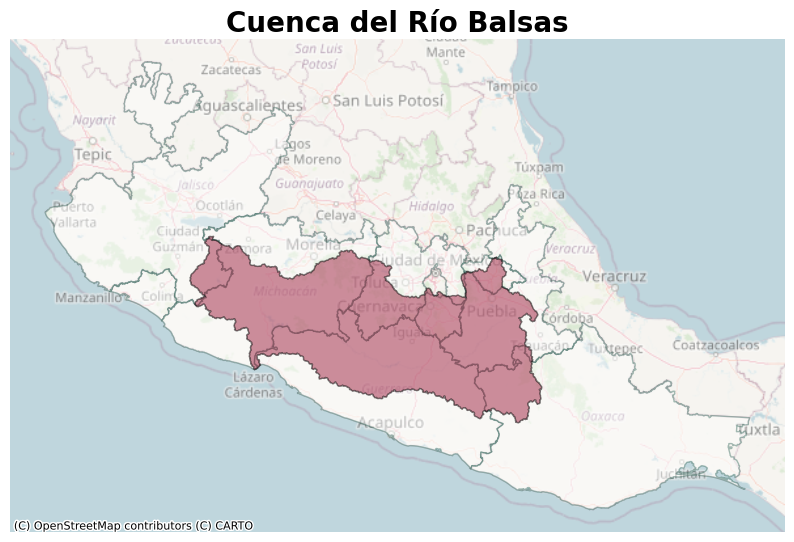

In [58]:
#Plot cuenca y estados

fig, ax = plt.subplots(figsize=(10, 10))

#Estados 
plt.title("Cuenca del Río Balsas", fontsize=20, fontweight='bold')
gdf_estados_cuenca.plot(ax=ax, color='white', edgecolor='#235b4e',alpha=0.4)
gdf_balsas.plot(ax=ax, color='#9f2241', edgecolor='black',alpha=0.5)
# Capas de OpenStreetMap y CartoDB
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)

#Eliminar bordes
ax.axis("off")

plt.savefig("cuenca_balsas.png", dpi=100, bbox_inches='tight',
            transparent=True)